In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from sklearn import svm, neighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
style.use('ggplot')

In [2]:
df = pd.read_csv('../sp500data/SP500PriceHistory.csv')
df.head()

Date         MMM        AOS        ABT       ABBV         ACN  \
0  2018-01-02  151.698502  54.426796  51.776566  71.669930  138.659607   
1  2018-01-03  151.692078  54.754086  51.891056  72.791473  139.299530   
2  2018-01-04  153.674942  55.010605  51.802990  72.376335  140.949005   
3  2018-01-05  154.872314  55.718262  51.952702  73.636276  142.111679   
4  2018-01-08  154.370178  55.983624  51.802990  72.456444  143.247330   

         ADBE    AMD       AES        AFL  ...        WMB         WTW  \
0  177.699997  10.98  8.634368  37.271648  ...  20.753771  133.155472   
1  181.039993  11.55  8.626430  37.381798  ...  21.326933  135.646622   
2  183.220001  12.12  8.594685  37.767357  ...  21.693491  137.023544   
3  185.339996  11.88  8.626430  38.017338  ...  21.633509  137.902252   
4  185.039993  12.28  8.626430  38.114780  ...  21.713486  137.159454   

         WDAY        WYNN        XEL        XYL        YUM        ZBRA  \
0  103.400002  151.862885  38.650253  62.594769  71.868065  103.709999   
1  105.169998  150.217606  38.391556  63.358021  71.806404  105.769997   
2  109.250000  151.031006  38.092449  63.780979  72.537430  107.860001   
3  109.320000  152.038544  37.825672  63.661457  72.960190  109.540001   
4  109.940002  150.014282  38.108616  63.891357  73.083496  110.629997   

          ZBH        ZTS  
0  114.007080  68.081055  
1  114.797379  68.394081  
2  114.631943  68.801994  
3  115.771446  69.589294  
4  115.991997  70.424095  

[5 rows x 504 columns]

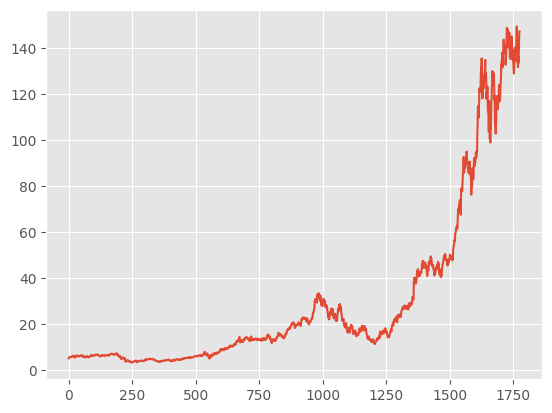

In [3]:
def visualize_data():
    df['NVDA'].plot()
    plt.show()

visualize_data()

           MMM       AOS       ABT      ABBV       ACN      ADBE       AMD  \
MMM   1.000000 -0.172537 -0.269834 -0.423610 -0.333568 -0.193249 -0.373286   
AOS  -0.172537  1.000000  0.657275  0.825793  0.832058  0.690911  0.851719   
ABT  -0.269834  0.657275  1.000000  0.691478  0.916541  0.848580  0.857741   
ABBV -0.423610  0.825793  0.691478  1.000000  0.847606  0.553215  0.828875   
ACN  -0.333568  0.832058  0.916541  0.847606  1.000000  0.848319  0.932686   

           AES       AFL         A  ...       WMB       WTW      WDAY  \
MMM  -0.235989 -0.312533 -0.253774  ... -0.241252 -0.280402 -0.112072   
AOS   0.362238  0.788005  0.747561  ...  0.753838  0.750810  0.656630   
ABT   0.748075  0.571482  0.921948  ...  0.537176  0.830265  0.788603   
ABBV  0.421481  0.904757  0.768962  ...  0.901467  0.846676  0.490805   
ACN   0.595549  0.769453  0.911573  ...  0.740175  0.880362  0.781461   

          WYNN       XEL       XYL       YUM      ZBRA       ZBH       ZTS  
MMM   0.476889 

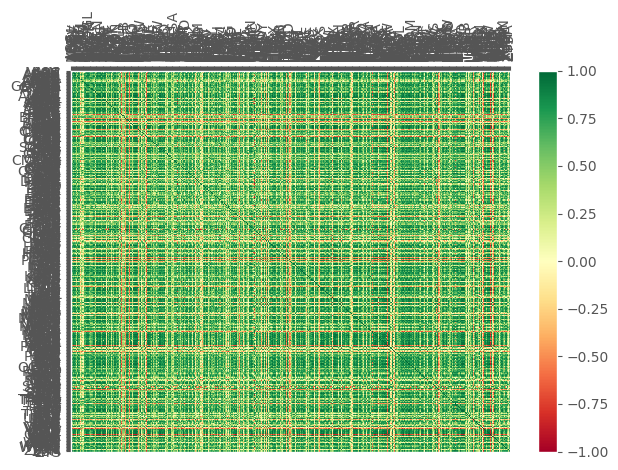

In [4]:
def visualize_data():
    df = pd.read_csv('../sp500data/SP500PriceHistory.csv')
    df_numeric = df.select_dtypes(include=[np.number])
    df_corr = df_numeric.corr()
    print(df_corr.head())
    df_corr.to_csv('../sp500data/sp500corr.csv')
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)

    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1, 1)
    plt.tight_layout()
    # plt.savefig("correlations.png", dpi=(300))
    plt.show()

visualize_data()

In [5]:
def process_data_for_labels(ticker):
    hm_days = 7
    df = pd.read_csv('../sp500data/SP500PriceHistory.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
    for i in range(1, hm_days+1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
    df.fillna(0, inplace=True)
    return tickers, df


def buy_sell_hold(*args):
    cols = [c for c in args]
    requirement = 0.02
    for col in cols:
        if col > requirement:
            return 1
        if col < -requirement:
            return -1
    return 0


def extract_featuresets(ticker):
    tickers, df = process_data_for_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)],
                                               df['{}_6d'.format(ticker)],
                                               df['{}_7d'.format(ticker)]))

    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:', Counter(str_vals))

    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)

    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)

    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
    return X, y, df

In [6]:
def do_ml(ticker):
    X, y, df = extract_featuresets(ticker)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    clf = VotingClassifier([('lsvc', svm.LinearSVC(C=0.5)),
                            ('knn', neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')),
                            ('rfor', RandomForestClassifier(n_estimators=250, max_depth=10, random_state=42))])
    

    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('accuracy:', confidence)
    predictions = clf.predict(X_test)
    print('predicted class counts:', Counter(predictions))
    print()
    print()
    return confidence

do_ml('AAPL')
do_ml('NVDA')
do_ml('GOOG')

Data spread: Counter({'1': 929, '-1': 629, '0': 217})
accuracy: 0.5292792792792793
predicted class counts: Counter({1: 395, -1: 49})


Data spread: Counter({'1': 971, '-1': 765, '0': 39})
accuracy: 0.4954954954954955
predicted class counts: Counter({1: 384, -1: 60})


Data spread: Counter({'1': 897, '-1': 658, '0': 220})
accuracy: 0.49324324324324326
predicted class counts: Counter({1: 402, -1: 42})




0.49324324324324326

In [ ]:
from statistics import mean

df_tickers = pd.read_csv('../sp500data/SP500StockInformation.csv')
tickers = df_tickers['Ticker'].tolist()

accuracies = []
for count, ticker in enumerate(tickers):
    if count % 10 == 0:
        print(count)
    try:
        accuracy = do_ml(ticker)
        accuracies.append(accuracy)
        print(f"{ticker} accuracy: {accuracy}. Average accuracy: {mean(accuracies)}")
    except Exception as e:
        print(f"Error processing {ticker}: {e}")